<a href="https://colab.research.google.com/github/vishal-burman/PyTorch-Architectures/blob/master/misc/Metric_Learning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [11]:
import random
from collections import defaultdict
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset
import torchvision
import torchvision.transforms as transforms
from torchvision.transforms import functional as F

In [2]:
# Hyperparameter Section
EPOCHS = 50
LR = 1e-3

In [4]:
transform = transforms.Compose([
                                transforms.ToTensor(),
                                transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

train_dataset = torchvision.datasets.CIFAR10(root='./data', 
                                             train=True, 
                                             transform=transform,
                                             download=True)
valid_dataset = torchvision.datasets.CIFAR10(root='/.data',
                                             train=False,
                                             transform=transform,
                                             download=True,
                                             )

Files already downloaded and verified
Files already downloaded and verified


In [5]:
# Form a lookup
sample_train_loader = DataLoader(train_dataset,
                                 batch_size=1,
                                 shuffle=False,)
sample_test_loader = DataLoader(valid_dataset,
                                batch_size=1,
                                shuffle=False)

x_train = [sample[0].squeeze(0).numpy() for sample in sample_train_loader]
y_train = [sample[1].item() for sample in sample_train_loader]

x_test = [sample[0].squeeze(0).numpy() for sample in sample_test_loader]
y_test = [sample[1].item() for sample in sample_test_loader]

class_idx_to_train = defaultdict(list)
for train_idx, y in enumerate(y_train):
  class_idx_to_train[y].append(train_idx)

class_idx_to_test = defaultdict(list)
for test_idx, y in enumerate(y_test):
  class_idx_to_test[y].append(test_idx)

In [6]:
# Check shape
print(x_train[0].shape, y_train[0])

(3, 32, 32) 6


In [7]:
class AnchorPositivePairs(Dataset):
  def __init__(self, class_idx_to_train, num_classes=10):
    self.class_idx_to_train = class_idx_to_train
    self.num_classes = num_classes

  def __len__(self,):
    return len(self.class_idx_to_train)
  
  def __getitem__(self, idx):
    anchors = []
    positives = []
    for batch_size in range(idx + 1):
      for class_idx in range(self.num_classes):
        examples_for_class = self.class_idx_to_train[class_idx]
        anchor_idx = random.choice(examples_for_class)
        positive_idx = random.choice(examples_for_class)
        while positive_idx == anchor_idx:
          positive_idx = random.choice(examples_for_class)
        anchors.append(x_train[anchor_idx])
        positives.append(x_train[positive_idx])
    return {
        'anchors': anchors,
        'positives': positives,
    }
  
  def collate_fn(self, batch):
    for sample in batch:
      anchors = sample['anchors']
      positives = sample['positives']
    anchors = torch.from_numpy(np.stack(anchors))
    positives = torch.from_numpy(np.stack(positives))
    return {
        'anchors': anchors,
        'positives': positives,
    }

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


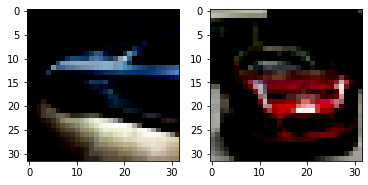

In [9]:
sample_dataset = AnchorPositivePairs(class_idx_to_train)
loader = DataLoader(sample_dataset, batch_size=1, collate_fn=sample_dataset.collate_fn)
for sample in loader:
  index = 1
  img_a = sample['anchors'][index]
  img_p = sample['positives'][index]
  fig, ax = plt.subplots(1, 2)
  ax[0].imshow(img_a.permute(1, 2, 0));
  ax[1].imshow(img_p.permute(1, 2, 0));
  break

In [21]:
class MetricEmbedding(nn.Module):
  def __init__(self,):
    super().__init__()
    self.layer_1 = nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, stride=2)
    self.layer_2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=2)
    self.layer_3 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, stride=2)
    self.pool = nn.AvgPool2d(kernel_size=3)
    self.output = nn.Linear(in_features=128, out_features=8)
    self.activation = nn.ReLU()

  def forward(self, x):
    x = self.activation(self.layer_1(x))
    x = self.activation(self.layer_2(x))
    x = self.activation(self.layer_3(x))
    x = self.pool(x).flatten(1)
    logits = self.output(x)
    return logits